# KAIST Summer Session 2018


## Cart Pole Problem using Deep Q-Network (08.27.2018)


## 0. Environment Setting

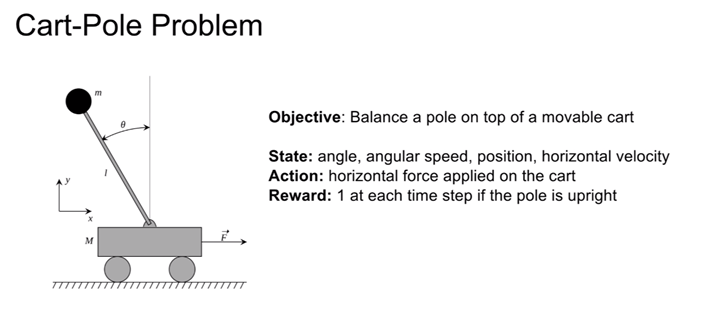

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
import random
import math
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')


learning_rate = 0.01
gamma = 1
num_episodes = 300
egreedy = 0.1


number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


## 1. Random Action

In [3]:
score_total = []

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0
    
    while True:
        
        action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        
        score += reward
              
        # env.render()
        
        if done:
            score_total.append(score)
            break
        
    if i_episode % 10 == 0:
        print("%i episode, Reward: %i" % (i_episode, score))      
        
env.close()

0 episode, Reward: 16
10 episode, Reward: 27
20 episode, Reward: 20
30 episode, Reward: 14
40 episode, Reward: 13
50 episode, Reward: 15
60 episode, Reward: 24
70 episode, Reward: 34
80 episode, Reward: 14
90 episode, Reward: 22
100 episode, Reward: 23
110 episode, Reward: 20
120 episode, Reward: 26
130 episode, Reward: 28
140 episode, Reward: 10
150 episode, Reward: 12
160 episode, Reward: 21
170 episode, Reward: 16
180 episode, Reward: 15
190 episode, Reward: 20
200 episode, Reward: 21
210 episode, Reward: 30
220 episode, Reward: 10
230 episode, Reward: 16
240 episode, Reward: 11
250 episode, Reward: 16
260 episode, Reward: 21
270 episode, Reward: 37
280 episode, Reward: 14
290 episode, Reward: 19


Success criterion of cart pole problem: 200 rewards
Average reward: 22.29
Average reward (last 100 episodes): 21.30


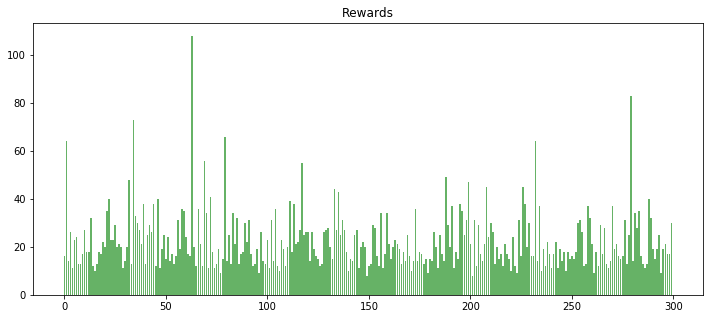

In [4]:
print("Success criterion of cart pole problem: 200 rewards")
print("Average reward: %.2f" % (sum(score_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(score_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(score_total)), score_total, alpha=0.6, color='green')
plt.show()

## 2. Q-Network

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs, number_of_outputs)
        
    def forward(self, x):
        output = self.linear1(x)
        return output

In [6]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork()

        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        # ϵ-Greedy Approach
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():  # no gradient calculation (not for learning)
                state = torch.Tensor(state)
                action_from_nn = self.nn(state)
                
                # choose the action with maximum Q-value from neural networks
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    
    def optimize(self, state, action, new_state, reward, done):  
        state = torch.Tensor(state)
        new_state = torch.Tensor(new_state)        
        reward = torch.Tensor([reward])
        
        if done:
            target_value = reward
        else:
            # target value is calculated from Q-network, rather than Q-table
            new_state_values = self.nn(new_state).detach() # no back-propagation (not for learning)
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        # learning to imitate the target value (from Bellman equation)
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [7]:
score_total = []

qnet_agent = QNet_Agent()


for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0

    while True:
        
        action = qnet_agent.select_action(state, egreedy/(i_episode+1))
        
        new_state, reward, done, info = env.step(action)
        
        score += reward

        qnet_agent.optimize(state, action, new_state, reward, done)
        
        state = new_state
        
        if done:
            score_total.append(score)
            break
            
        
    if i_episode % 10 == 0:
        print("%i episode, Reward: %i" % (i_episode, score))      
        
env.close()  

0 episode, Reward: 9
10 episode, Reward: 9
20 episode, Reward: 10
30 episode, Reward: 10
40 episode, Reward: 9
50 episode, Reward: 10
60 episode, Reward: 8
70 episode, Reward: 10
80 episode, Reward: 10
90 episode, Reward: 9
100 episode, Reward: 9
110 episode, Reward: 9
120 episode, Reward: 9
130 episode, Reward: 9
140 episode, Reward: 11
150 episode, Reward: 9
160 episode, Reward: 10
170 episode, Reward: 8
180 episode, Reward: 10
190 episode, Reward: 9
200 episode, Reward: 9
210 episode, Reward: 11
220 episode, Reward: 9
230 episode, Reward: 9
240 episode, Reward: 10
250 episode, Reward: 8
260 episode, Reward: 9
270 episode, Reward: 9
280 episode, Reward: 10
290 episode, Reward: 9


Success criterion of cart pole problem: 200 rewards
Average reward: 9.30
Average reward (last 100 episodes): 9.28


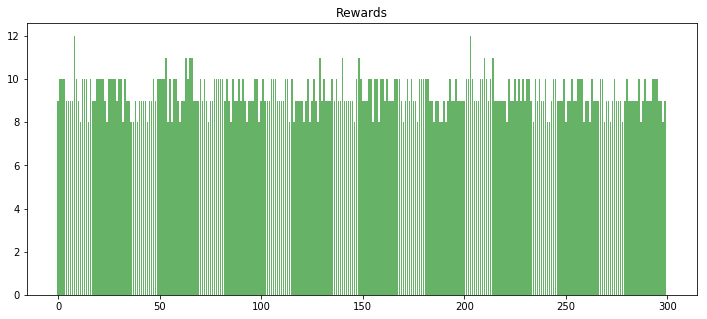

In [8]:
print("Success criterion of cart pole problem: 200 rewards")
print("Average reward: %.2f" % (sum(score_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(score_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(score_total)), score_total, alpha=0.6, color='green')
plt.show()

## 3. Deep Q-Network

### 3.1. Go deeper

In [9]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs, 64)
        self.linear2 = nn.Linear(64, number_of_outputs)      
        
    def forward(self, x):
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

In [10]:
class QNet_Agent2(object):
    def __init__(self):
        self.nn = NeuralNetwork2()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        # ϵ-Greedy Approach
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():  # no gradient calculation (not for learning)
                state = torch.Tensor(state)
                action_from_nn = self.nn(state)
                
                # choose the action with maximum Q-value from neural networks
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    
    def optimize(self, state, action, new_state, reward, done):  
        state = torch.Tensor(state)
        new_state = torch.Tensor(new_state)        
        reward = torch.Tensor([reward])
        
        if done:
            target_value = reward
        else:
            # target value is calculated from Q-network, rather than Q-table
            new_state_values = self.nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values)
            target_value = reward + gamma * max_new_state_values
        
        predicted_value = self.nn(state)[action]
        
        # learning to imitate the target value (from Bellman equation)
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [11]:
score_total = []

qnet_agent2 = QNet_Agent2()

for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0

    while True:
  
        action = qnet_agent2.select_action(state, egreedy/(i_episode+1))
        
        new_state, reward, done, info = env.step(action)
        
        score += reward

        qnet_agent2.optimize(state, action, new_state, reward, done)
        
        state = new_state
        
        if done:
            score_total.append(score)
            break
            
        
    if i_episode % 10 == 0:
        print("%i episode, Reward: %i" % (i_episode, score))    

0 episode, Reward: 12
10 episode, Reward: 9
20 episode, Reward: 12
30 episode, Reward: 34
40 episode, Reward: 19
50 episode, Reward: 85
60 episode, Reward: 23
70 episode, Reward: 49
80 episode, Reward: 91
90 episode, Reward: 149
100 episode, Reward: 24
110 episode, Reward: 126
120 episode, Reward: 281
130 episode, Reward: 389
140 episode, Reward: 13
150 episode, Reward: 382
160 episode, Reward: 357
170 episode, Reward: 306
180 episode, Reward: 223
190 episode, Reward: 498
200 episode, Reward: 500
210 episode, Reward: 154
220 episode, Reward: 12
230 episode, Reward: 500
240 episode, Reward: 256
250 episode, Reward: 500
260 episode, Reward: 500
270 episode, Reward: 500
280 episode, Reward: 500
290 episode, Reward: 347


Success criterion of cart pole problem: 200 rewards
Average reward: 249.45
Average reward (last 100 episodes): 417.54


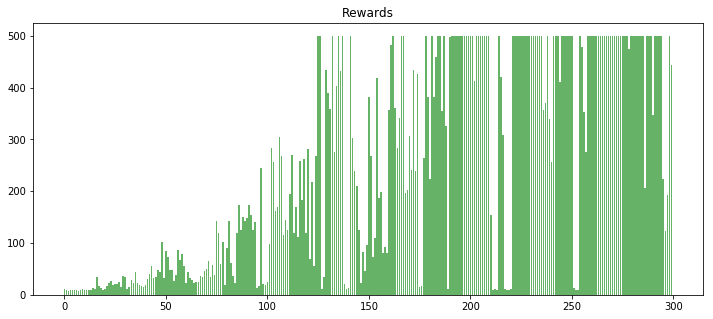

In [12]:
print("Success criterion of cart pole problem: 200 rewards")
print("Average reward: %.2f" % (sum(score_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(score_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(score_total)), score_total, alpha=0.6, color='green')
plt.show()

### 3.2. Experience replay (memory)

In [13]:
class QNet_Agent3(object):
    def __init__(self):
        self.nn = NeuralNetwork2()
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        # ϵ-Greedy Approach
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():  # no gradient calculation (not for learning)
                state = torch.Tensor(state)
                action_from_nn = self.nn(state)
                
                # choose the action with maximum Q-value from neural networks
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    
    def optimize(self, state, action, new_state, reward, done):  
       
        state = torch.Tensor(state)
        action = torch.LongTensor(action)
        new_state = torch.Tensor(new_state)        
        reward = torch.Tensor(reward)
        done = torch.Tensor(done)
        
        # target value is calculated from Q-network, rather than Q-table
        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
 
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        # learning to imitate the target value (from Bellman equation)
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()        
        self.optimizer.step()

In [14]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
 
    def push(self, state, action, new_state, reward, done):
        
        transition = (state, action, new_state, reward, done)
        self.memory.append(transition)

        if len(self.memory) > self.capacity:
            del self.memory[0]
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
        
        
    def __len__(self):
        return len(self.memory)

In [15]:
score_total = []
replay_mem_size = 50000
batch_size = 32


qnet_agent3 = QNet_Agent3()
memory = ExperienceReplay(replay_mem_size)


for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0

    while True:
  
        action = qnet_agent3.select_action(state, egreedy/(i_episode+1))
        
        new_state, reward, done, info = env.step(action)
        
        score += reward
        
    # learning from random sample in the experience memory, rather than from successive observations   
    ##############################################################################
        memory.push(state, action, new_state, reward, done)
        
        if (len(memory) > batch_size):
            state_batch, action_batch, new_state_batch, reward_batch, done_batch = memory.sample(batch_size)
            qnet_agent3.optimize(state_batch, action_batch, new_state_batch, reward_batch, done_batch)
            
    ##############################################################################
        
        state = new_state
        
        if done:
            score_total.append(score)
            break
            
        
    if i_episode % 10 == 0:
        print("%i episode, Reward: %i" % (i_episode, score))  

0 episode, Reward: 11
10 episode, Reward: 15
20 episode, Reward: 113
30 episode, Reward: 221
40 episode, Reward: 297
50 episode, Reward: 500
60 episode, Reward: 486
70 episode, Reward: 292
80 episode, Reward: 291
90 episode, Reward: 421
100 episode, Reward: 500
110 episode, Reward: 500
120 episode, Reward: 500
130 episode, Reward: 500
140 episode, Reward: 234
150 episode, Reward: 251
160 episode, Reward: 500
170 episode, Reward: 500
180 episode, Reward: 500
190 episode, Reward: 188
200 episode, Reward: 429
210 episode, Reward: 500
220 episode, Reward: 500
230 episode, Reward: 500
240 episode, Reward: 400
250 episode, Reward: 500
260 episode, Reward: 500
270 episode, Reward: 500
280 episode, Reward: 500
290 episode, Reward: 17


Success criterion of cart pole problem: 200 rewards
Average reward: 394.42
Average reward (last 100 episodes): 434.46


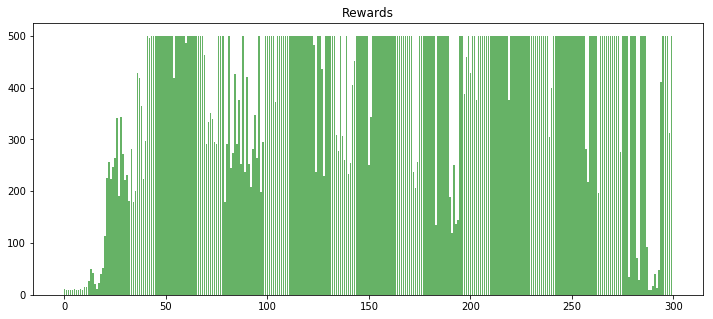

In [16]:
print("Success criterion of cart pole problem: 200 rewards")
print("Average reward: %.2f" % (sum(score_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(score_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(score_total)), score_total, alpha=0.6, color='green')
plt.show()

### 3.3. Separating learning and target networks

In [17]:
class QNet_Agent4(object):
    def __init__(self):
        
    # learning and target networks are instantiated separately
    ##############################################################################
        self.nn = NeuralNetwork2()    
        self.target_nn = NeuralNetwork2()
    ##############################################################################
    
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.number_of_frames = 0
        
    
    def select_action(self,state,epsilon):
        
        random_for_egreedy = torch.rand(1)[0]
        
        # ϵ-Greedy Approach
        if random_for_egreedy > epsilon:      
            
            with torch.no_grad():  # no gradient calculation (not for learning)
                state = torch.Tensor(state)
                action_from_nn = self.nn(state)
                
                # choose the action with maximum Q-value from neural networks
                action = torch.max(action_from_nn,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    
    def optimize(self, state, action, new_state, reward, done):  
       
        state = torch.Tensor(state)
        action = torch.LongTensor(action)
        new_state = torch.Tensor(new_state)        
        reward = torch.Tensor(reward)
        done = torch.Tensor(done)

        
    ##############################################################################
    
        # target value is calculated from target network
        new_state_values = self.target_nn(new_state).detach()    
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
        
        # predicted value is calculated from learning network
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
    
    ##############################################################################
        
        # learning to imitate the target value (from Bellman equation)
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()                    
        self.optimizer.step()
    
    
        # copy from learning network into target network after several steps
    ##############################################################################
        if self.number_of_frames % update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.number_of_frames += 1
    ##############################################################################

In [20]:
score_total = []
replay_mem_size = 50000
batch_size = 32
update_target_frequency = 100


qnet_agent4 = QNet_Agent4()
memory2 = ExperienceReplay(replay_mem_size)


for i_episode in range(num_episodes):
    
    state = env.reset()
    
    score = 0

    while True:
  
        action = qnet_agent4.select_action(state, egreedy/(i_episode+1))
        
        new_state, reward, done, info = env.step(action)
        
        score += reward 

        # learning from random sample in the experience memory, rather than from successive observations
        memory2.push(state, action, new_state, reward, done)
        
        if (len(memory2) > batch_size):
            state_batch, action_batch, new_state_batch, reward_batch, done_batch = memory2.sample(batch_size)
            qnet_agent4.optimize(state_batch, action_batch, new_state_batch, reward_batch, done_batch)
        
        state = new_state
        
        if done:
            score_total.append(score)
            break
            
        
    if i_episode % 10 == 0:
        print("%i episode, Reward: %i" % (i_episode, score))   

0 episode, Reward: 9
10 episode, Reward: 10
20 episode, Reward: 10
30 episode, Reward: 14
40 episode, Reward: 17
50 episode, Reward: 9
60 episode, Reward: 23
70 episode, Reward: 456
80 episode, Reward: 243
90 episode, Reward: 243
100 episode, Reward: 178
110 episode, Reward: 177
120 episode, Reward: 269
130 episode, Reward: 270
140 episode, Reward: 381
150 episode, Reward: 236
160 episode, Reward: 457
170 episode, Reward: 500
180 episode, Reward: 335
190 episode, Reward: 500
200 episode, Reward: 500
210 episode, Reward: 500
220 episode, Reward: 500
230 episode, Reward: 500
240 episode, Reward: 500
250 episode, Reward: 500
260 episode, Reward: 500
270 episode, Reward: 500
280 episode, Reward: 500
290 episode, Reward: 224


Success criterion of cart pole problem: 200 rewards
Average reward: 297.39
Average reward (last 100 episodes): 477.46


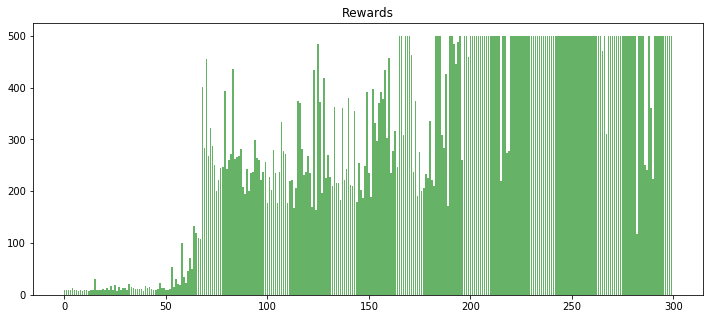

In [21]:
print("Success criterion of cart pole problem: 200 rewards")
print("Average reward: %.2f" % (sum(score_total)/num_episodes))
print("Average reward (last 100 episodes): %.2f" % (sum(score_total[-100:])/100))

plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.bar(torch.arange(len(score_total)), score_total, alpha=0.6, color='green')
plt.show()